# Preparation

In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = "/home/denis/Documents/practice/recsys-itmo-spring-2023/botify/data/"
data = pd.read_json(DATA_DIR + "dataIndexedBIG.json", lines=True)

In [3]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-04-13 09:44:04.991,6391,11831,1.0,0.000451,27049.0,{'AA': 'C'}
1,next,2023-04-13 09:44:04.998,6391,27049,0.0,0.000365,8436.0,{'AA': 'C'}
2,next,2023-04-13 09:44:05.005,6391,8436,1.0,0.000408,20615.0,{'AA': 'C'}
3,next,2023-04-13 09:44:05.014,6391,20615,0.0,0.000425,20419.0,{'AA': 'C'}
4,next,2023-04-13 09:44:05.019,6391,11831,1.0,0.000367,36292.0,{'AA': 'C'}


In [4]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])


def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))

        if row["message"] == "last":
            first = None
    return pairs

In [5]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

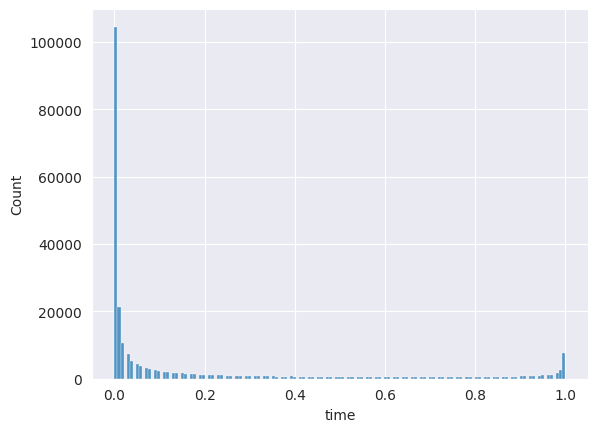

In [6]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

In [7]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(195377, 24501, 24250)

# Models

In [35]:
class ContextualRankerTracks(pl.LightningModule):
    def __init__(self, embedding_dim=100):
        super().__init__()
        self.embedding_dim = embedding_dim

        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 1]) # start track
        track = self.track(x[:, 2]) # next track
        return torch.sum(context * track, dim=1)

    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [38]:
class ContextualRankerUsers(pl.LightningModule):
    def __init__(self, embedding_dim=100):
        super().__init__()
        self.embedding_dim = embedding_dim

        self.context = nn.Embedding(num_embeddings=10000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # user
        track = self.track(x[:, 2]) # next track
        return torch.sum(context * track, dim=1)

    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [39]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm=np.random.random(len(self.test_data))).assign(
            avg=self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values),
                torch.from_numpy(self.train_data["time"].values)
            )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values),
                torch.from_numpy(self.val_data["time"].values)
            )

        if stage == "test" or stage is None:
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
            )

    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

# Training

### Tracks net training

In [40]:
net = ContextualRankerTracks()
data_module = ContextualRankerData(train_data, val_data, test_data, features=["user", "start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    devices=1,
    accelerator='gpu',
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=10),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    net,
    data_module
)


  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 1.3 M 
1 | track   | Embedding | 6.4 M 
2 | linear1 | Linear    | 32.9 K
3 | linear2 | Linear    | 129   
4 | relu    | ReLU      | 0     
--------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/denis/.virtualenvs/recsys-itmo-spring-2023/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/denis/.virtualenvs/recsys-itmo-spring-2023/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Tracks net evaluation

In [42]:
best_tracks = ContextualRankerTracks.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)

In [43]:
trainer.test(best_tracks, data_module)

/home/denis/.virtualenvs/recsys-itmo-spring-2023/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.0953572615981102
        rdm_loss            0.2797442078590393
        test_loss           0.08937074989080429
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08937074989080429,
  'avg_loss': 0.0953572615981102,
  'rdm_loss': 0.2797442078590393}]

### Users net training

In [50]:
net = ContextualRankerUsers()
data_module = ContextualRankerData(train_data, val_data, test_data, features=["user", "start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu',
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [51]:
trainer.fit(
    net,
    data_module
)


  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 1.3 M 
1 | track   | Embedding | 6.4 M 
2 | linear1 | Linear    | 32.9 K
3 | linear2 | Linear    | 129   
4 | relu    | ReLU      | 0     
--------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/denis/.virtualenvs/recsys-itmo-spring-2023/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/denis/.virtualenvs/recsys-itmo-spring-2023/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

### Users net evaluation

In [52]:
best_users = best = ContextualRankerUsers.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)
trainer.test(best_users, data_module)

/home/denis/.virtualenvs/recsys-itmo-spring-2023/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.0953572615981102
        rdm_loss            0.28040042519569397
        test_loss           0.08857240527868271
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08857240527868271,
  'avg_loss': 0.0953572615981102,
  'rdm_loss': 0.28040042519569397}]

# Recommendations preparation

### Save tracks info

In [44]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [ ]:
context_embeddings = dict(best_tracks.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best_tracks.named_parameters())["track.weight"].data.cpu().numpy()

In [49]:
k = 100
with open(DATA_DIR + "tracks_recommendations.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]

        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()

        rf.write(json.dumps(recommendation) + "\n")

50000it [29:38, 28.12it/s]


### Save users info

In [58]:
users_meta = pd.read_json(DATA_DIR + "users.json", lines=True)

In [ ]:
context_embeddings = dict(best_users.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best_users.named_parameters())["track.weight"].data.cpu().numpy()

In [60]:
k = 100
with open(DATA_DIR + "users_recommendations.json", "w") as rf:
    for _, user in tqdm.tqdm(users_meta.iterrows()):
        embedding = context_embeddings[user["user"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]

        recommendation = dict(user)
        recommendation["recommendations"] = neighbours.tolist()

        rf.write(json.dumps(recommendation) + "\n")

10000it [05:25, 30.73it/s]
